# Как выбирать размер выборки

*Подготовил Ян Пиле*

Часто, когда собираются проводить АБ-тест, процесс происходит следующим образом:
    
1) К вам приходит менеджер и говорит: "Хочу провести АБ с нововведением Х и увеличить тем самым метрику Y" (например $X = \text{новый алгоритм ранжирования в ленте новостей}$, а $Y = CTR$\)

2) "А какой размер эффекта мы хотим увидеть?"-, спрашиваете Вы.

3) "Какой будет, такой и хотим увидеть,"- отвечает менеджер

Естественно, так ничего не заработает :) Очевидно вы понимаете, что для измерения любого сколь угодно малого эффекта вам нужно иметь бесконечное количество пользователей и, вероятно, бесконечное время проводить эксперимент.

Так что же, в итоге, делать?

# Калькуляторы размеров выборки

In [2]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
from scipy import stats # Статистика
from scipy.stats import norm, ttest_ind
%matplotlib inline

In [3]:
34168/60/60

9.491111111111111

Вероятно для оценки размера выборки вы видели вот такую формулу.

$$n > \frac{\left[ \Phi^{-1} \left( 1-\alpha \right) + \Phi^{-1} \left( 1-\beta \right) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Здесь $\varepsilon$ - размер эффекта, $\alpha$ - вероятность ошибки первого рода, $\beta$ - вероятность ошибки 2 рода

А 
<img src = "https://alexanderdyakonov.files.wordpress.com/2019/05/d0b01.jpg?w=700">

Где здесь какая ошибка?



In [3]:
def compute_sample_size_abs(epsilon, std1, std2, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (std1 ** 2 + std2 ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

# Как на самом деле сосчитать размер выборки. 

## Допустим, мы считаем наш CTR

In [9]:
q = """
select views, count() as users
from (select  
    exp_group,
    user_id,
    sum(action = 'view') as views
from simulator.feed_actions
where toDate(time) between '2021-11-08' and '2021-11-14'
    and exp_group in (1,2,3,4,5)
group by exp_group, user_id
)
group by views
order by views
"""


views_distribution = pandahouse.read_clickhouse(q, connection=connection)

In [11]:
# Заранее сохранил

views_distribution.to_csv('views_08_14.csv', index = False)

In [33]:
(views_distribution.users * views_distribution.views).sum()/views_distribution.users.sum()

73.84261458608252

In [422]:
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()

In [423]:
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
15,16,427,0.012522
14,15,420,0.012316
16,17,420,0.012316
13,14,394,0.011554
30,31,394,0.011554
...,...,...,...
287,289,1,0.000029
288,290,1,0.000029
291,293,1,0.000029
292,294,1,0.000029


In [28]:
(views_distribution.views * views_distribution.p).sum()

73.84261458608252

## Вот наше настоящее распределение просмотров

Возьмем нашу гистограмму, которую считали в прошлой ячейке, и сделаем из нее дискретное распределение (из которого мы потом будем семплировать количество просмотров)

In [424]:
views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))

In [428]:
views_distr.rvs(size = 1000).mean()

73.035

У $CTR$ разброс где-то от 0.2 до 0.22 по дням. Запомним это)

Достанем распределение CTR'ов за неделю

In [12]:
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator.feed_actions
where dt between '2021-11-08' and '2021-11-14'
    and exp_group in (1,2,3,4,5)
group by dt, exp_group, user_id
)
group by ctr
"""


ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()

In [13]:
# Заранее сохранил

ctr_distribution.to_csv('ctr_08_14.csv', index = False)

In [431]:
probabilities = ctr_distribution['p']
values = ctr_distribution['ctr']
distrib = stats.rv_discrete(values=(range(len(probabilities)), probabilities))

def get_ctrs(x, y):
    idx = distrib.rvs(size=x*y)
    result = values[idx]
    return np.array(result).reshape(x,y)

Так, средний CTR у нас был 0.21. допустим, мы хотим замечать изменение на 0.01 (то есть это на 5%)

# Синтетический А-А тест

In [436]:
q = """
select 
   stddevPop(ctr) as ctr_std
from (select 
    exp_group,
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator.feed_actions
where toDate(time) between '2021-11-08' and '2021-11-14'
    and exp_group in (1,2,3,4,5)
group by exp_group, user_id
)

"""

std = pandahouse.read_clickhouse(q, connection=connection).values[0][0]
std

0.0811515533741262

In [14]:
std = 0.0811515533741262

In [437]:
compute_sample_size_abs(0.01, std, std)

1034

In [438]:
0.01/0.21

0.04761904761904762

## Попробуем 1447, 1600, 1800

In [439]:
group_A_views = views_distr.rvs(size = (2000, 1100))
group_B_views = views_distr.rvs(size = (2000, 1100))
group_A_ctr = get_ctrs(2000, 1100)*1.048
group_B_ctr = get_ctrs(2000,1100)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [80]:
0.01/get_ctrs(2000,1800).mean()

0.047316750538454765

In [82]:
def t_test(a, b):
    """
    Считает p-value для t-теста с двусторонней альтернативой 
    :param a: np.array вида (n_experiments, n_users), значения метрик в контрольных группах
    :param b: np.array вида (n_experiments, n_users), значения метрик в тестовых группах
    :return: np.array вида (n_experiments), посчитанные p-value t-теста для всего списка экспериментов
    """
    result = list(map(lambda x: stats.ttest_ind(
        x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [440]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.5235

In [84]:
t_test(clicks_A, clicks_B).shape

(2000,)

# Что-то мы промахиваемся, кажется)

In [441]:
def get_1_minus_beta(N, alpha = 0.05, std1 = std, std2 = std, epsilon = 0.01):
    z_scores_sum_squared = N / ((std1 ** 2 + std2 ** 2) / (epsilon ** 2))
    
    talpha_plus_tbeta = np.sqrt(z_scores_sum_squared)
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = talpha_plus_tbeta - t_alpha
    _1_minus_beta = norm.cdf(t_beta, loc=0, scale=1)
    
    return _1_minus_beta

In [443]:
def get_1_minus_beta_t_test(N, effect = 1.048):
    group_A_views = views_distr.rvs(size = (1000, N))
    group_B_views = views_distr.rvs(size = (1000, N))
    group_A_ctr = get_ctrs(1000, N)*effect
    group_B_ctr = get_ctrs(1000,N)
    clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
    clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
    return np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/1000

In [89]:
get_1_minus_beta_t_test(1447)

0.6495

In [444]:
%%time
# Это я тут считаю долю "найденной" разницы

xs = np.arange(700,2501,100)

_1_minus_beta_normal = get_1_minus_beta(xs)
_1_minus_beta_monte_carlo = np.array([get_1_minus_beta_t_test(i) for i in xs])

CPU times: user 45.2 s, sys: 11.6 s, total: 56.8 s
Wall time: 57.7 s


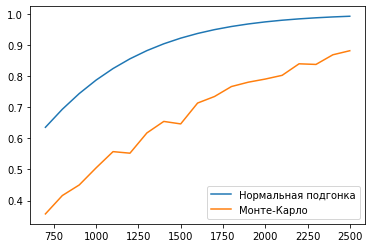

In [445]:
_ = plt.plot(xs, _1_minus_beta_normal, label = 'Нормальная подгонка')
_ = plt.plot(xs, _1_minus_beta_monte_carlo, label = 'Монте-Карло')
plt.legend()


То есть тут мы "Недозаложились". 

# Бакетное преобразование

In [446]:
def bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    """
    Разбиваем на бакеты с весами
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), веса пользователей в контрольной группе
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), веса пользователей в целевой группе
    :param n_buckets: int, кол-во бакетов
    :return: np.array shape (n_experiments), средневзвешенные метрики в каждом бакете
    """

    n_experiments, n_users = ctrs_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int)
        values_0[:, b] = np.sum(ctrs_0[:, ind] * weights_0[:, ind], axis=1) / np.sum(weights_0[:, ind], axis=1)
        values_1[:, b] = np.sum(ctrs_1[:, ind] * weights_1[:, ind], axis=1) / np.sum(weights_1[:, ind], axis=1)

    return values_0, values_1

In [447]:
def mannwhitney(a, b):
    """
    Двусторонний тест Манна-Уитни
    :param a: np.array вида (n_experiments, n_users), значения метрики в контроле
    :param b: np.array вида (n_experiments, n_users), значен я метрики в тесте
    :return: np.array вида (n_experiments), двусторонние p-value методом Манна-Уитни для всех экспериментов
    """
    result = list(map(lambda x: stats.mannwhitneyu(
        x[0], x[1], alternative='two-sided').pvalue, zip(a, b)))
    return np.array(result)

In [448]:
# t-тест поверх бакетов
def t_test_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return t_test(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

# тест Манна-Уитни поверх бакетов
def mannwhitney_buckets(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets=100):
    return mannwhitney(*bucketization(ctrs_0, weights_0, ctrs_1, weights_1, n_buckets))

In [106]:
def get_1_minus_beta_t_test_buckets(N, effect = 1.047):
    group_A_views = views_distr.rvs(size = (2000, N))
    group_B_views = views_distr.rvs(size = (2000, N))
    group_A_ctr = get_ctrs(2000, N)*effect
    group_B_ctr = get_ctrs(2000,N)
    clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
    clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
    return np.sum(t_test_buckets(clicks_A/group_A_views, 
                                 group_A_views,
                                 clicks_B/group_B_views, 
                                 group_B_views)<= 0.05)/2000

In [449]:
_1_minus_beta_monte_carlo_buckets = np.array([get_1_minus_beta_t_test_buckets(i) for i in xs])

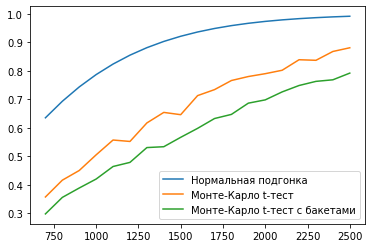

In [450]:
_ = plt.plot(xs, _1_minus_beta_normal, label = 'Нормальная подгонка')
_ = plt.plot(xs, _1_minus_beta_monte_carlo, label = 'Монте-Карло t-тест')
_ = plt.plot(xs, _1_minus_beta_monte_carlo_buckets, label = 'Монте-Карло t-тест с бакетами')
plt.legend()

# Ну ОК, а зачем тогда вообще бакеты... (к этому чуть позже)

# Линеаризация

In [109]:
def get_1_minus_beta_linearized(N, effect = 1.047):
    group_A_views = views_distr.rvs(size = (2000, N))
    group_B_views = views_distr.rvs(size = (2000, N))
    group_A_ctr = get_ctrs(2000, N)*effect
    group_B_ctr = get_ctrs(2000,N)
    clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
    clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
    control_ctr = stats.binom.rvs(group_B_views, group_B_ctr).sum(axis = 1)/group_B_views.sum(axis = 1)
    linearized_A = clicks_A - (group_A_views.T*control_ctr).T
    linearized_B = clicks_B - (group_B_views.T*control_ctr).T
    linearization_p_values = t_test(linearized_A, linearized_B)
    return np.sum(linearization_p_values<= 0.05)/2000

In [110]:
_1_minus_beta_monte_carlo_linearization = np.array([get_1_minus_beta_linearized(i) for i in xs])

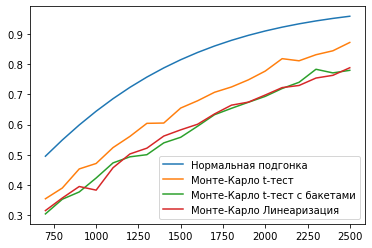

In [111]:
_ = plt.plot(xs, _1_minus_beta_normal, label = 'Нормальная подгонка')
_ = plt.plot(xs, _1_minus_beta_monte_carlo, label = 'Монте-Карло t-тест')
_ = plt.plot(xs, _1_minus_beta_monte_carlo_buckets, label = 'Монте-Карло t-тест с бакетами')
_ = plt.plot(xs, _1_minus_beta_monte_carlo_linearization, label = 'Монте-Карло Линеаризация')
plt.legend()

# А на самом деле просмотры обычно выглядят не так...

In [451]:
mu = 1
sigma2 = 2
N = 1447
experiments = 1000
views_lognormal = np.absolute(np.exp(norm(mu, sigma2).rvs(
    experiments * N)).astype(np.int64).reshape(experiments, N) + 1)

Text(0.5, 1.0, 'Views, 99%-ile = 285.0  ')

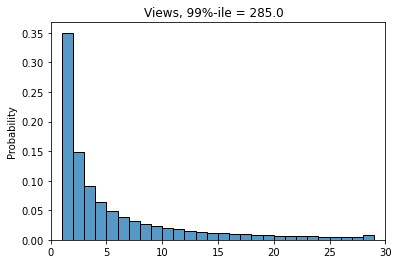

In [452]:
fig = plt.figure()
ax_views = fig.add_subplot()
views_distr = sns.histplot(views_lognormal.ravel(),  # Теперь это массив длины experiments * N
                           bins=range(0, 30),
                           kde=False,
                           ax=ax_views,
                           stat='probability')
ax_views.set_xlim((0, 30))
views_99_percentile = np.percentile(views_lognormal.ravel(), 99)
ax_views.set_title(f'Views, 99%-ile = {views_99_percentile:<7.1f}')

In [453]:
def get_views(experiments, N, mu = 1, sigma = 2):
    views_lognormal = np.absolute(
        np.exp(
            norm(mu, 
                 sigma2).rvs(experiments * N)
        ).astype(np.int64).reshape(experiments, N) + 1)
    return views_lognormal

(array([ 20.,  12.,  55.,  67., 109., 219., 186., 218., 257., 153., 219.,
         99.,  77., 106.,  38.,  38.,  47.,  21.,   9.,  14.,   0.,  18.,
          7.,   2.,   0.,   4.,   1.,   2.,   0.,   2.]),
 array([0.        , 0.00236667, 0.00473333, 0.0071    , 0.00946667,
        0.01183333, 0.0142    , 0.01656667, 0.01893333, 0.0213    ,
        0.02366667, 0.02603333, 0.0284    , 0.03076667, 0.03313333,
        0.0355    , 0.03786667, 0.04023333, 0.0426    , 0.04496667,
        0.04733333, 0.0497    , 0.05206667, 0.05443333, 0.0568    ,
        0.05916667, 0.06153333, 0.0639    , 0.06626667, 0.06863333,
        0.071     ]),
 <a list of 30 Patch objects>)

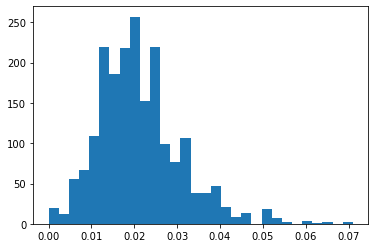

In [456]:
plt.hist(get_ctrs(2000,1)/10, bins = 30)

Допустим, мне "сверху" пришло откровение о ctr'ах и они оказались "прямо как в прошлом примере" (настоящие),только я их на 10 разделю, вот только просмотры теперь стали логнормальными

In [465]:
group_A_views = get_views(2000, 10000)
group_B_views = get_views(2000, 10000)
group_A_ctr = (get_ctrs(2000, 10000)/10)*1.2
group_A_ctr[group_A_ctr>1] = 1
group_B_ctr = (get_ctrs(2000, 10000)/10)
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

(2000, 40000)

In [466]:
group_B_ctr.std()

0.009599141240925705

In [471]:
my_new_std = (clicks_B/group_B_views).std()
my_new_std

0.09688135105060922

In [472]:
compute_sample_size_abs(0.005, my_new_std, my_new_std)

5894

# Ок, на 12 тысячах должны увидеть

In [473]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.851

In [474]:
np.sum(t_test_buckets(clicks_A/group_A_views, 
                      group_A_views,
                      clicks_B/group_B_views, 
                      group_B_views)<= 0.05)/2000

1.0

хех) а тут бакеты выиграли)

Ну хорошо! А что если мое изменение вдруг повлияло на всех НЕ ОДИНАКОВО и оно 0.05 только В СРЕДНЕМ

In [159]:
from scipy.stats import beta

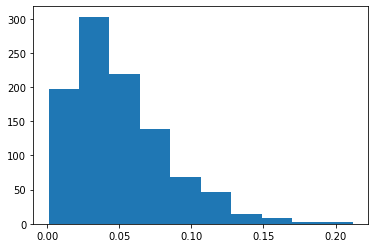

In [173]:
effect = beta.rvs(2,38, size = 1000)

_ = plt.hist(effect)

In [177]:
beta.rvs(2,38, size = 1000).mean()

0.050989184592994646

In [182]:
beta.rvs(2,38, size = 10000000).min()

1.0349885584026128e-05

In [226]:
effect = norm.rvs(1.05,0.05, size = (2000, 12000))

In [227]:
effect.max()

1.3294481514431302

# А если конверсия будет поменьше?

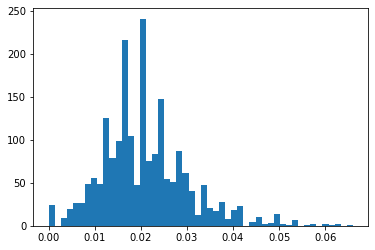

In [475]:
_ = plt.hist(get_ctrs(2000, 1)/10, bins = 50)

In [290]:
group_A_views = get_views(2000, 12000)
group_B_views = get_views(2000, 12000)
group_A_ctr = (get_ctrs(2000, 12000)/10)*1.2
group_A_ctr[group_A_ctr > 1]= 1
group_B_ctr = get_ctrs(2000,12000)/10


In [291]:
clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)

In [292]:
(clicks_A/group_A_views)[0].mean(), (clicks_B/group_B_views)[0].mean()

(0.026062217977741792, 0.022242828962342618)

In [293]:
np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

0.888

In [294]:
np.sum(mannwhitney_buckets(clicks_A/group_A_views, 
                      group_A_views,
                      clicks_B/group_B_views, 
                      group_B_views)<= 0.05)/2000

1.0

In [476]:
def get_1_minus_beta_t_test_lognormal(N, effect = 1.2, divide_by = 10):
    group_A_views = get_views(2000, N)
    group_B_views = get_views(2000, N)
    group_A_ctr = (get_ctrs(2000, N)/divide_by)*effect
    group_B_ctr = (get_ctrs(2000,N)/divide_by)
    clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
    clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
    return np.sum(t_test(clicks_A/group_A_views, clicks_B/group_B_views)<= 0.05)/2000

def get_1_minus_beta_t_test_buckets_lognormal(N, effect = 1.2, divide_by = 10):
    group_A_views = get_views(2000, N)
    group_B_views = get_views(2000, N)
    group_A_ctr = (get_ctrs(2000, N)/divide_by)*effect
    group_B_ctr = (get_ctrs(2000, N)/divide_by)
    clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
    clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
    return np.sum(t_test_buckets(clicks_A/group_A_views, 
                                 group_A_views,
                                 clicks_B/group_B_views, 
                                 group_B_views)<= 0.05)/2000

def get_1_minus_beta_mw_buckets_lognormal(N, effect = 1.2, divide_by = 10):
    group_A_views = get_views(2000, N)
    group_B_views = get_views(2000, N)
    group_A_ctr = (get_ctrs(2000, N)/divide_by)*effect
    group_B_ctr = (get_ctrs(2000, N)/divide_by)
    clicks_A = stats.binom.rvs(group_A_views, group_A_ctr)
    clicks_B = stats.binom.rvs(group_B_views, group_B_ctr)
    return np.sum(mannwhitney_buckets(clicks_A/group_A_views, 
                                 group_A_views,
                                 clicks_B/group_B_views, 
                                 group_B_views)<= 0.05)/2000

CPU times: user 4min 37s, sys: 1min 16s, total: 5min 54s
Wall time: 5min 57s


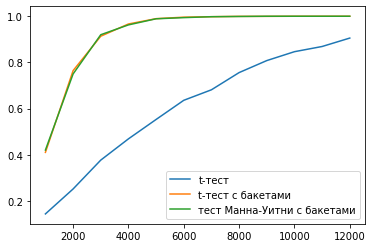

In [477]:
%%time
xs = np.arange(1000,12001,1000)

_1_minus_beta_t_test = np.array([get_1_minus_beta_t_test_lognormal(i, 
                                                                   divide_by = 10) for i in xs])
_1_minus_beta_t_test_buckets = np.array([get_1_minus_beta_t_test_buckets_lognormal(i, 
                                                                                   divide_by = 10) for i in xs])
_1_minus_beta_mw_buckets = np.array([get_1_minus_beta_mw_buckets_lognormal(i, 
                                                                           divide_by = 10) for i in xs])
_ = plt.plot(xs, _1_minus_beta_t_test, label = 't-тест')
_ = plt.plot(xs, _1_minus_beta_t_test_buckets, label = 't-тест с бакетами')
_ = plt.plot(xs, _1_minus_beta_mw_buckets, label = 'тест Манна-Уитни с бакетами')
plt.legend()

In [478]:
0.2/3

0.06666666666666667

# А если чуток побольше?

CPU times: user 4min 41s, sys: 1min 12s, total: 5min 53s
Wall time: 5min 56s


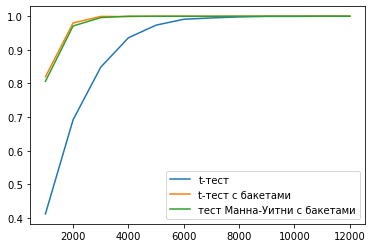

In [306]:
%%time
xs = np.arange(1000,12001,1000)

_1_minus_beta_t_test = np.array([get_1_minus_beta_t_test_lognormal(i, 
                                                                   divide_by = 3) for i in xs])
_1_minus_beta_t_test_buckets = np.array([get_1_minus_beta_t_test_buckets_lognormal(i, 
                                                                                   divide_by = 3) for i in xs])
_1_minus_beta_mw_buckets = np.array([get_1_minus_beta_mw_buckets_lognormal(i, 
                                                                           divide_by = 3) for i in xs])
_ = plt.plot(xs, _1_minus_beta_t_test, label = 't-тест')
_ = plt.plot(xs, _1_minus_beta_t_test_buckets, label = 't-тест с бакетами')
_ = plt.plot(xs, _1_minus_beta_mw_buckets, label = 'тест Манна-Уитни с бакетами')
plt.legend()

CPU times: user 4min 55s, sys: 1min 15s, total: 6min 11s
Wall time: 6min 15s


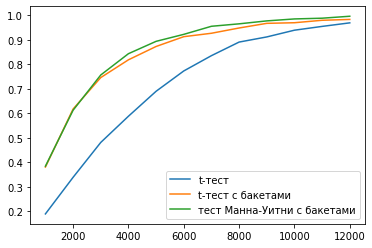

In [310]:
%%time
xs = np.arange(1000,12001,1000)

_1_minus_beta_t_test = np.array([get_1_minus_beta_t_test_lognormal(i, effect = 1.1,
                                                                   divide_by = 2) for i in xs])
_1_minus_beta_t_test_buckets = np.array([get_1_minus_beta_t_test_buckets_lognormal(i, effect = 1.1,
                                                                                   divide_by = 2) for i in xs])
_1_minus_beta_mw_buckets = np.array([get_1_minus_beta_mw_buckets_lognormal(i, effect = 1.1,
                                                                           divide_by = 2) for i in xs])
_ = plt.plot(xs, _1_minus_beta_t_test, label = 't-тест')
_ = plt.plot(xs, _1_minus_beta_t_test_buckets, label = 't-тест с бакетами')
_ = plt.plot(xs, _1_minus_beta_mw_buckets, label = 'тест Манна-Уитни с бакетами')
plt.legend()